# TP1 - Compressão e Descompressão de Imagem

### Alunos:

Vinicius Silva Gomes - 2021421869

João Antonio Oliveira Pedrosa - 2019006752

# Abordagem utilizada para compressão
Antes de aplicar qualquer tipo de tratativa na imagem, a primeira coisa que fazemos é aplicar um padding nela, de modo que ela se torne um múltiplo de 8 e todos os nossos métodos possam ser executados de maneira correta e sem nenhum tipo falha por causa das dimensões da imagem.

## Primeiro método
Para aplicar a compressão nas imagens, desenvolvemos dois métodos de compressão.

O primeiro deles é inspirado no que é feito pelo método de compressão JPEG, diferenciando pelo passo final, no qual ao invés de utilizarmos a Codificação de Huffman para corrigir o problema da redundância de códigos, tentamos uma abordagem diferente, nos aproveitando da grande quantidade de zeros para codificar com um array com sufixos 0 (estratégia onde o primeiro elemento do array é o número de zeros que aparecem após o fim dos valores diferentes de 0 naquela linha).

Dessa forma, resumindo o método, aplicamos a Transformada Discreta do Cosseno em grids de 8x8 na imagem fornecida. Após passá-la para o domínio de frequência, eliminamos os coeficientes de alta frequência com uma tabela de quantização (usamos a tabela padrão usada pelo JPEG pois ela possui uma taxa de compressão interessante sem comprometer a imagem de maneira grave). Codificamos os códigos através do método explicado no parágrafo anterior e salvamos num arquivo binário com a nossa própria extensão.

Para a descompressão é feito um processo análogo, no qual traduzimos os códigos do arquivo salvo para a imagem original, multiplicamos blocos 8x8 pela matriz de quantização e aplicamos a Transformada Inversa do Cosseno, onde retiramos a imagem do domínio de frequência e a devolvemos para o domínio espacial.

## Segundo método
O segundo método é baseado na Codificação Preditiva do Erro com Perdas. Nele, nós tratamos a imagem baseado na função g(x, y) = ĝ(x - 1, y). Com isso, é possível reduzir a quantidade de bits representados na imagem. Para comprimir ainda mais, aplicamos uma quantização no erro obtido da Codificação Preditiva do Erro e definimos que pixels variem apenas 4 bits serão mapeados para o menor deles (pixels de 0 a 3 serão mapeados para 0, de 4 a 7 serão mapeados para 4 e assim por diante).

Por fim, utilizaremos essa matrix quantizada dos erros para reduzir a redundância de código através de Codificação de Huffman e salvaremos em disco o resultado dessa codificação em um arquivo binário com extensão própria criada por nós.

Para descompressão, o processo também é análogo. Decodificaremos a imagem salva em disco através dos códigos gerados pela Codificação de Huffman e aplicaremos a função contrária da Codificaão Preditiva do Erro, de modo a obter os coeficientes "originais" novamente. "Originais" pois como houve uma quantização desses coeficientes, alguns deles estarão diferentes dos que existiam na imagem original e é essa perda ligeira de bits que reduz um pouco a qualidade da imagem, em prol, obviamente, de mais compressão após a Codificação de Huffman.

In [1]:
# Library import

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import queue
import ast

from skimage.metrics import structural_similarity as ssim

In [2]:
# Variables and auxiliar functions

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def compression_rate(original_image, compressed_image):
    original_image_size = os.stat('source.jpg').st_size
    compressed_image_size = os.stat('compressed.jpg').st_size
    
    return original_image_size/compressed_image_size

SQ = 8

# Default quantization matrix implemented by JPEG compression method
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]])

Dimensões da imagem: 512x512
Tamanho da imagem (em disco): 0.262178 MB / 262.178 kB


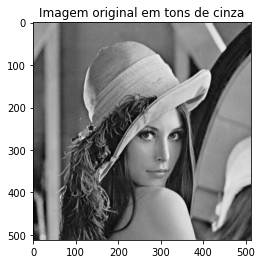

In [92]:
# Importing the image and information about it's dimensions and size

src_img = cv2.imread('lena512.pgm', 0)
src_img_size = os.stat('lena512.pgm').st_size

print("Dimensões da imagem: {}x{}".format(src_img.shape[1], src_img.shape[0]))
print("Tamanho da imagem (em disco): {} MB / {} kB".format(src_img_size/10 ** 6, src_img_size/10 ** 3))

plt.title("Imagem original em tons de cinza")
plt.imshow(src_img, cmap="gray")

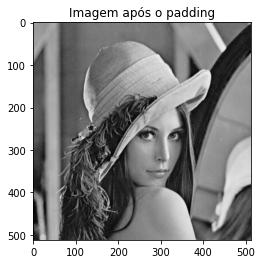

In [93]:
# Padding image

img_shape = src_img.shape

lin    = img_shape[0]
col    = img_shape[1]

xpad   = (SQ - lin % SQ) % SQ
ypad   = (SQ - col % SQ) % SQ

padded_img = src_img
padded_img = np.append(padded_img, np.full((xpad, col)        , 255), axis = 0)
padded_img = np.append(padded_img, np.full((lin + xpad, ypad) , 255), axis = 1)

plt.title("Imagem após o padding")
plt.imshow(padded_img, cmap="gray")

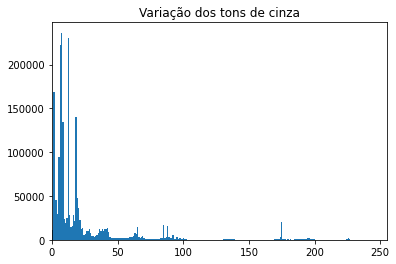

In [79]:
# Histogram with image gray levels

flattered_img = padded_img.ravel()

plt.hist(flattered_img, 256, [0,255]);
plt.xlim([0, 255])
plt.title("Variação dos tons de cinza")
plt.show()

## Primeiro método de Compressão
Transformada Discreta do Cosseno + Quantização através da tabela padrão utilizada pelo JPEG + Codificação através de prefixos de 0

In [6]:
# Function that receives a SQ x SQ block and applies DCT Transform + Quantization

def apply_dct(image):
    image -= 128
    image =  image.astype(float)
    return cv2.dct(image)

def apply_idct(image):
    image =  image.astype(float)
    image = cv2.idct(image)
    image += 128
    return image

def simplify(block):
    local_dct        = apply_dct(block)
    local_quant      = local_dct / quant_matrix
    local_quant      = local_quant.round()
    # Huffman Encoding
    # Aqui a gente salva!
    # Huffman Decoding
    local_simplified = apply_idct(local_quant * quant_matrix)
    
    return local_simplified

RMSE: 4.133250767135528
PSNR: 35.80496850822563


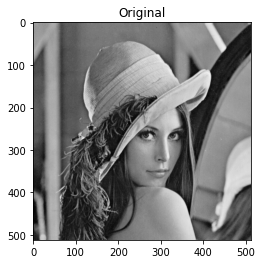

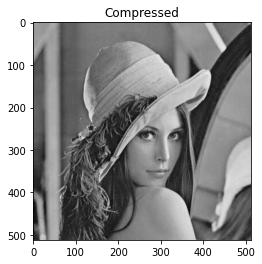

In [7]:
# Iterating
padded_img_shape = padded_img.shape

lin = padded_img_shape[0]
col = padded_img_shape[1]

dct_full = np.zeros(padded_img_shape)

for l in range(0, lin, SQ):
    for c in range(0, col, SQ):
        dct_full[l:l+SQ, c:c+SQ] = simplify(padded_img[l:l+SQ, c:c+SQ].copy())

plt.title("Original")
plt.imshow(padded_img, cmap="gray",)
plt.figure()

plt.title("Compressed")
plt.imshow(dct_full, cmap="gray")

print("RMSE:", rmse(padded_img, dct_full))
print("PSNR:", psnr(padded_img, dct_full))
# print("Taxa de Compressão:", compression_rate(padded_img, dct_full))

In [32]:
# Saving
cv2.imwrite("results/original.png", padded)
cv2.imwrite("results/compressed.png", dct_full)

True

## Segundo método de Compressão
Codificação Preditiva do Erro com Perdas + Codificação de Huffman para reduzir a redundância de código e salvar menos bytes em disco.

In [7]:
# Variables and auxiliar functions

quantization_level = 4

def preditive_encode(img):
    preditive = img.copy()
    
    for i in range(0, lin):
        for j in range(0, col):
            if(j != 0):
                preditive[i, j] -= preditive[i, j - 1]
                
    return preditive

def preditive_decode(preditive):
    img = preditive.copy()
    
    for i in range(0, lin):
        for j in range(0, col):
            if(j != 0):
                img[i, j] += preditive[i, j - 1]
                
    return img

# def quantizate(matrix):
#     quantizated = matrix.copy()
    
#     for i in range(0, quantizated.shape[0]):
#         for j in range(0, quantizated.shape[1]):
#             if(quantizated[i, j] % quantization_level):
                
                
#     return quantizated

In [8]:
class Node:
    def __init__(self):
        self.prob = None
        self.code = None
        self.data = None
        self.left = None
        self.right = None
    def __lt__(self, other):
        if (self.prob < other.prob):
            return 1
        else:
            return 0
    def __ge__(self, other):
        if (self.prob > other.prob):
            return 1
        else:
            return 0

def tree(probabilities):
    prq = queue.PriorityQueue()
    for color,probability in enumerate(probabilities):
        leaf = Node()
        leaf.data = color
        leaf.prob = probability
        prq.put(leaf)

    while (prq.qsize()>1):
        newnode = Node()
        l = prq.get()
        r = prq.get()
        newnode.left = l
        newnode.right = r
        newprob = l.prob+r.prob
        newnode.prob = newprob
        prq.put(newnode)
    return prq.get()

def huffman_traversal(root_node, tmp_array, huffman_dict):
    if (root_node.left is not None):
        tmp_array[huffman_traversal.count] = 1
        huffman_traversal.count+=1
        huffman_traversal(root_node.left,tmp_array,huffman_dict)
        huffman_traversal.count-=1
    if (root_node.right is not None):
        tmp_array[huffman_traversal.count] = 0
        huffman_traversal.count+=1
        huffman_traversal(root_node.right,tmp_array,huffman_dict)
        huffman_traversal.count-=1
    else:
        huffman_traversal.output_bits[root_node.data] = huffman_traversal.count
        bitstream = ''.join(str(cell) for cell in tmp_array[1:huffman_traversal.count]) 
        color = str(root_node.data)
        huffman_dict[color] = bitstream
    return

def huffman_encode(img):
    hist = np.bincount(img.ravel(), minlength=256)
    probabilities = hist / np.sum(hist)

    root_node = tree(probabilities)
    tmp_array = np.ones([64],dtype=int)
    huffman_traversal.output_bits = np.empty(256, dtype = 'uint8') 
    huffman_traversal.count = 0

    huffman_dict = {}
    huffman_traversal(root_node, tmp_array, huffman_dict)
    
    return huffman_dict

In [26]:
# preditive_matrix = preditive_encode(padded_img)     
# quantizated = quantizate(preditive_matrix)

# Compressing the image

huffman_dict = huffman_encode(padded_img)

coded_img = padded_img.copy()

for i in range(0, coded_img.shape[0]):
    for j in range(0, coded_img.shape[1]):
        coded_img[i, j] = int(huffman_dict[str(coded_img[i, j])], 2)
        
file = open("compressed.qocm", "w")

file.write('{}x{}\n'.format(padded_img.shape[0], padded_img.shape[1]))
file.write(str(huffman_dict))

file.write('\n')

for row in coded_img:
    np.savetxt(file, row, fmt='%i')
    
file.close()

In [28]:
# Uncompressing the image

file = open("compressed.qocm", "r")

dimensions = file.readline()
dimensions = dimensions.split('x')
dimensions = [int(i) for i in dimensions]

huffman_dict = file.readline()
huffman_dict = ast.literal_eval(huffman_dict)

raw_img = np.loadtxt(file).reshape(dimensions[0], dimensions[1])
raw_img = raw_img.astype(int)

file.close()

decoded_img = raw_img.copy()
decoded_img = decoded_img.astype(int)

reverse_dict = dict(zip(huffman_dict.values(), huffman_dict.keys()))

for i in range(0, dimensions[0]):
    for j in range(0, dimensions[1]):
        decoded_img[i, j] = reverse_dict[format(decoded_img[i, j], "b")]
        
# decoded_matrix = preditive_decode(preditive_matrix)
                
plt.title("Original")
plt.imshow(padded_img, cmap="gray",)
plt.figure()

plt.title("Compressed")
plt.imshow(decoded_img, cmap="gray")

print("RMSE:", rmse(padded_img, decoded_img))
print("PSNR:", psnr(padded_img, decoded_img))

KeyError: '11111'

## Terceiro método de compressão
Compressão baseado na Decomposição em Valores Singulares

In [129]:
def svd_compression(img):
    U, sigma, V = np.linalg.svd(img, full_matrices=False) # calcula o U, V e os valores singulares da imagem
    
    rank = len(sigma)
    
    k = round(0.1 * rank)
        
    U_new = U[:,:k] # colunas menores que k de U
    V_new = V[:k,:] # colunas menores que k de V
    S_new = np.zeros((k, k), int) # matriz com os maiores k elementos da diagonal
    
    for i in range(k):
        S_new[i][i] = sigma[i]
        
    file = open("results/compressed_svd.bin" ,"wb")
    
    np.save(file, U_new)
    np.save(file, S_new)
    np.save(file, V_new)
    
    file.close()

def svd_decompression():
    file = open("results/compressed_svd.bin" ,"rb")
    
    U = np.load(file)
    sigma = np.load(file)
    V = np.load(file)
    
    file.close()
        
    uncompressed_img = np.dot(np.dot(U, sigma), V) # multiplica as matrizes para calcular a nova imagem
    
    return uncompressed_img

RMSE: 7.7860218856618975
PSNR: 30.30449120590951


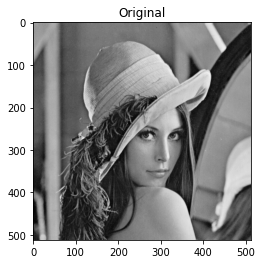

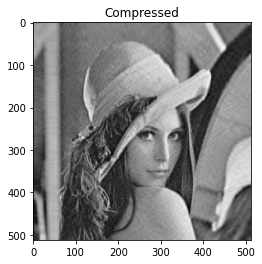

In [130]:
svd_compression(padded_img)

uncompressed_img = svd_decompression()

plt.title("Original")
plt.imshow(padded_img, cmap="gray",)
plt.figure()

plt.title("Compressed")
plt.imshow(uncompressed_img, cmap="gray")

print("RMSE:", rmse(padded_img, uncompressed_img))
print("PSNR:", psnr(padded_img, uncompressed_img))